# Pummels In Pittsburgh

Below is the analysis of our data set, involving the car crashes in Pittsburgh from 2004-2015. We attempt to create a model to predict the severity of the car crash, and use some of these models to determine which features tell us the most about the crash severity.

Note: A lot of our functionality was implemented in the cleaning.py and training.py classes, to allow us to work on the logic simultaneously via Visual Studio Live Share. Please see those files for more implementation information.

## Importing Data 

In [89]:
import cleaning as cleaning
import train as train
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import tree, svm, ensemble, neighbors, naive_bayes, neural_network
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

data = cleaning.get_data("crash.csv")
cleaning.data_info(data)

    CRASH_CRN  DISTRICT  CRASH_COUNTY  MUNICIPALITY POLICE_AGCY  CRASH_YEAR  \
0  2004000001        11             2          2454       02454        2004   
1  2004000010        11             2          2440       02440        2004   
2  2004000016        11             2          2203       02203        2004   
3  2004000022        11             2          2404       02404        2004   
4  2004000030        11             2          2419       02419        2004   

   CRASH_MONTH  DAY_OF_WEEK  TIME_OF_DAY  HOUR_OF_DAY  ...  LANE_COUNT  \
0            1            5        257.0          2.0  ...         2.0   
1            1            5       1027.0         10.0  ...         2.0   
2            1            5       1839.0         18.0  ...         2.0   
3            1            6        914.0          9.0  ...         2.0   
4            1            5       2230.0         22.0  ...         2.0   

   RDWY_ORIENT  ROAD_OWNER  ROUTE  SPEED_LIMIT  SEGMENT  OFFSET  \
0            

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (79,183,189) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


## Dimensionality Reduction
With over 190 features and 100,000+ records, our data set started off very large. In order to make more classifiers such as KNN viable, we need to eliminate features using various criteria.

In [104]:
# drop manually choosen columns which do not have anything to do with our predictions
data = data.drop(data[cleaning.drops], axis=1) 

# drop anything having to do with the severity, to avoid label leakage
data = data.drop(data[cleaning.sev_metric], axis=1) 

data.shape

(182782, 136)

In [91]:
# drop cols with a lot of missing vals
data = cleaning.drop_missing_vals(data) 

data.shape

Dropping columns with missing values > 10%:
Index(['RDWY_SURF_TYPE_CD', 'SPEC_JURIS_CD', 'TFC_DETOUR_IND',
       'WORK_ZONE_TYPE', 'WORK_ZONE_LOC', 'CONS_ZONE_SPD_LIM', 'WORKERS_PRES',
       'WZ_CLOSE_DETOUR', 'WZ_FLAGGER', 'WZ_LAW_OFFCR_IND', 'WZ_LN_CLOSURE',
       'WZ_MOVING', 'WZ_OTHER', 'WZ_SHLDER_MDN'],
      dtype='object')


(182782, 121)

In [92]:
# drop highly corr features
data = cleaning.drop_highly_correlated_features(data)

Dropping 18 highly correlated columns
['LOCAL_ROAD_ONLY', 'INTERSECTION', 'MOTORCYCLE', 'BICYCLE', 'HVY_TRUCK_RELATED', 'DRINKING_DRIVER', 'DRIVER_16YR', 'DRIVER_17YR', 'DRIVER_65_74YR', 'DRIVER_75PLUS', 'DRIVER_18YR', 'DRIVER_19YR', 'DRIVER_20YR', 'DRIVER_50_64YR', 'COMM_VEHICLE', 'IMPAIRED_DRIVER', 'DEER_RELATED', 'DRUG_RELATED']


## Data Cleaning
We found many instances of missing values, strangely formatted features and simply unnecessary columns. Below, we run the code contained in clean.py to sanitize these values

In [93]:
# change Y/N to bool values
data = cleaning.yn_to_bool(data, cleaning.yn_columns) 

# drop rows that aren't in pittsburg
data = cleaning.fix_lat_long(data)

# drop cols with strings
data = cleaning.get_rid_of_strs(data)

cleaning.data_info(data)

    CRASH_MONTH  DAY_OF_WEEK  HOUR_OF_DAY  ILLUMINATION  WEATHER  \
0             1            5          2.0             2      1.0   
1             1            5         10.0             1      1.0   
2             1            5         18.0             2      1.0   
6             1            6         14.0             1      1.0   
11            1            1         19.0             3      2.0   

    ROAD_CONDITION  COLLISION_TYPE  RELATION_TO_ROAD  INTERSECT_TYPE  \
0              0.0               7                 2               0   
1              6.0               7                 5               0   
2              0.0               7                 5               3   
6              0.0               1                 1               0   
11             1.0               2                 1               3   

    TCD_TYPE  ...  DRUGGED_DRIVER  HAZARDOUS_TRUCK  ILLEGAL_DRUG_RELATED  \
0          0  ...               0                0                     0   
1     

## Note: Downsampling of Data to Run In Notebook

While we ran our results and graphs on the full data set, training in Jupyter Notebook with 100% records results in crashes. The prediction code we are using as a sample will be run with a subset, then!

Because of the very highly reduced amount of data, our accuracies are much lower than we found using the full data set. Please see the paper for actual results.

In [94]:
# From here on out, we will only use a random 5% subset of the data
percent_to_use = 0.05
data, _, _, _ = sk.model_selection.train_test_split(data, data['MAX_SEVERITY_LEVEL'], test_size=1-percent_to_use)

## Training
We wrote up a generic system to verify the results of many classifiers. Below are some of the classifiers we tested, with their necessary pipelines. The rest of the code for actually running the pipeline and printing the output is contained in train.py

In [95]:
# Get a list of categorical column names that have not yet been filtered out from data cleaning
def get_column_index(name):
    return data.columns.get_loc(name)
cols = [x for x in cleaning.categorical_columns if x in data.columns]
categorical_columns = list(map(get_column_index, cols))

In [96]:
# Here we define our pipelines with our potential hyperparameters. 
# Only some fo the classifiers need some of the transformers, so we need the flexibilty
# to specify which.
one_hot_transformer = OneHotEncoder(handle_unknown='ignore', categorical_features=categorical_columns, sparse=False)
numeric_transformer = SimpleImputer(strategy="median")
under_sampler = RandomUnderSampler(sampling_strategy="auto", return_indices=False, random_state=None, replacement=False, ratio=None)

pipelines = [
    (
        "Decision Tree",
        {
            'classifier__max_depth' : [10,15,20], 
            'classifier__min_samples_leaf' : [10,15,20],
            'classifier__max_features' : [5,10,15]
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('classifier', tree.DecisionTreeClassifier(criterion='entropy'))])
    ),
    (
        "K Nearest Neighbor",
        {
            'classifier__n_neighbors' : [3, 5, 7], 
            'pca__n_components' : [10, 25]
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('encoder', one_hot_transformer),
                        ('std_scaler', StandardScaler()),
                        ('pca', PCA()),
                        ('classifier', neighbors.KNeighborsClassifier())])
    ),
    (
        "Support Vector Machine",
        {
            'classifier__kernel' : ['linear', 'poly'], 
            'classifier__degree' : [1, 3],
            'pca__n_components' : [10, 25]
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('encoder', one_hot_transformer),
                        ('std_scaler', StandardScaler()),
                        ('pca', PCA()),
                        ('classifier', svm.SVC())])
    ),
    (
        "Random Forest",
        {
            'classifier__max_depth' : [5,10,15], 
            'classifier__min_samples_leaf' : [10, 20],
            'classifier__n_estimators' : [100, 1000]
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('encoder', one_hot_transformer),
                        ('classifier', ensemble.RandomForestClassifier())])
    ),
    (
        "Neural Net (MLP)",
        {
            'classifier__activation' : ['logistic', 'tanh', 'relu'],
            'classifier__hidden_layer_sizes' : list(range(30, 61, 10)) 
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('encoder', one_hot_transformer),
                        ('std_scaler', StandardScaler()),
                        ('classifier', neural_network.MLPClassifier())])
    ),
    (
        "AdaBoost",
        {
            'classifier__n_estimators' : [50, 100, 150],
        },
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('classifier', ensemble.AdaBoostClassifier())])
    ),
    (
        "Gaussian Naive Bayes",
        {},
        Pipeline(steps=[('preprocessor', numeric_transformer),
                        ('undersampler', under_sampler),
                        ('encoder', one_hot_transformer),
                        ('classifier', naive_bayes.GaussianNB())])
    )
]

# Run through each of our pipelines and print out a classification report
# on the data. 
train.predict_severity(data, pipelines)

/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   16.1s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished



Information for Decision Tree cross-validated model

Accuracy = 0.5617

Confusion Matrix:
[[3310  300  206  318  368]
 [   1   26   11    9    7]
 [   9   71   33   26   33]
 [  39  248  143  192  173]
 [ 104  420  255  365  420]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.74      0.83      4502
           1       0.02      0.48      0.05        54
           2       0.05      0.19      0.08       172
           3       0.21      0.24      0.23       795
           4       0.42      0.27      0.33      1564

    accuracy                           0.56      7087
   macro avg       0.33      0.38      0.30      7087
weighted avg       0.72      0.56      0.63      7087



/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.2s finished



Information for K Nearest Neighbor cross-validated model

Accuracy = 0.3917

Confusion Matrix:
[[2296  307  577  526  796]
 [  12   20   13    3    6]
 [  45   41   37   24   25]
 [ 257  120  171  115  132]
 [ 591  176  268  221  308]]

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.51      0.60      4502
           1       0.03      0.37      0.06        54
           2       0.03      0.22      0.06       172
           3       0.13      0.14      0.14       795
           4       0.24      0.20      0.22      1564

    accuracy                           0.39      7087
   macro avg       0.23      0.29      0.21      7087
weighted avg       0.52      0.39      0.44      7087



/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    8.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished



Information for Support Vector Machine cross-validated model

Accuracy = 0.4679

Confusion Matrix:
[[2640  226  403  546  687]
 [   4   27   13    5    5]
 [  13   41   58   36   24]
 [ 107  164  185  165  174]
 [ 236  196  314  392  426]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.59      0.70      4502
           1       0.04      0.50      0.08        54
           2       0.06      0.34      0.10       172
           3       0.14      0.21      0.17       795
           4       0.32      0.27      0.30      1564

    accuracy                           0.47      7087
   macro avg       0.29      0.38      0.27      7087
weighted avg       0.65      0.47      0.53      7087



/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.5min remaining:   59.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished



Information for Random Forest cross-validated model

Accuracy = 0.7565

Confusion Matrix:
[[4431   27    6   10   28]
 [   1   28   10    9    6]
 [   2   52   28   43   47]
 [   8  187  164  155  281]
 [  21  316  189  319  719]]

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4502
           1       0.05      0.52      0.08        54
           2       0.07      0.16      0.10       172
           3       0.29      0.19      0.23       795
           4       0.67      0.46      0.54      1564

    accuracy                           0.76      7087
   macro avg       0.41      0.46      0.39      7087
weighted avg       0.81      0.76      0.78      7087

Most important features for Random Forest:
['URBAN_RURAL', 'LOCATION_TYPE', 'SCH_BUS_IND', 'SCH_ZONE_IND', 'MOTORCYCLE_COUNT', 'BUS_COUNT', 'SMALL_TRUCK_COUNT', 'VAN_COUNT', 'BICYCLE_COUNT', 'UNBELTED_OCC_COUNT', 'COMM_VEH_COUNT', 'DRIVER_COUNT_16YR', 'DRI

/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   39.0s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.9s finished



Information for Neural Net (MLP) cross-validated model

Accuracy = 0.5407

Confusion Matrix:
[[3030  279  305  409  479]
 [   6   22   15    7    4]
 [   9   42   52   36   33]
 [  44  122  201  211  217]
 [ 166  183  263  435  517]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      4502
           1       0.03      0.41      0.06        54
           2       0.06      0.30      0.10       172
           3       0.19      0.27      0.22       795
           4       0.41      0.33      0.37      1564

    accuracy                           0.54      7087
   macro avg       0.33      0.40      0.31      7087
weighted avg       0.71      0.54      0.61      7087



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.6s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.6s finished



Information for AdaBoost cross-validated model

Accuracy = 0.7133

Confusion Matrix:
[[4435   17   32    9    9]
 [   0   17   22   10    5]
 [   0   46   65   35   26]
 [   0  167  297  155  176]
 [   0  303  546  332  383]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4502
           1       0.03      0.31      0.06        54
           2       0.07      0.38      0.11       172
           3       0.29      0.19      0.23       795
           4       0.64      0.24      0.35      1564

    accuracy                           0.71      7087
   macro avg       0.40      0.42      0.35      7087
weighted avg       0.81      0.71      0.74      7087



/u/cfrantz/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.8s remaining:    1.9s



Information for Gaussian Naive Bayes cross-validated model

Accuracy = 0.6774

Confusion Matrix:
[[3870  103  128  163  238]
 [   0   10   15   16   13]
 [   4   11   54   56   47]
 [  21   59  186  251  278]
 [  54   88  285  521  616]]

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      4502
           1       0.04      0.19      0.06        54
           2       0.08      0.31      0.13       172
           3       0.25      0.32      0.28       795
           4       0.52      0.39      0.45      1564

    accuracy                           0.68      7087
   macro avg       0.37      0.41      0.37      7087
weighted avg       0.77      0.68      0.72      7087



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished


## Charts and Visualizations
Below are some of the more interesting relationships we found, in a visual form

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (79,183,189) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


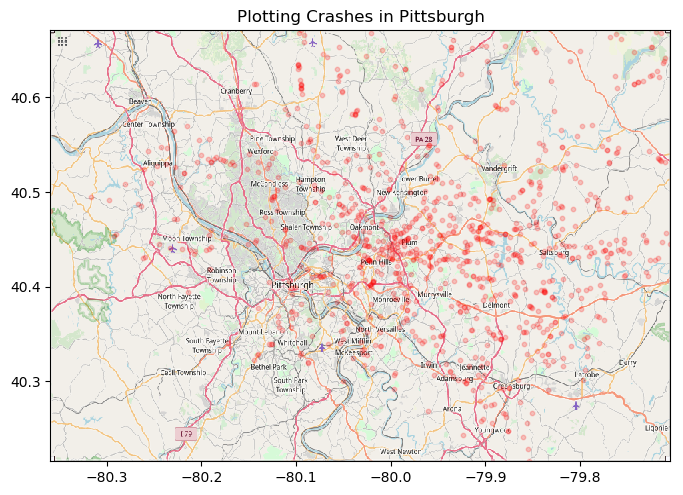

In [97]:
data = cleaning.get_data("crash.csv")

def plot_fatal_accidents(data):

    # Only get fatal crashes
    data = data[data['FATAL'] == 1]

    # Get n% of data
    n = 1
    data = (data.head(int(len(data)*n)))

    boundingBox = [data.DEC_LONG.min(),data.DEC_LONG.max(), data.DEC_LAT.min(), data.DEC_LAT.max()]
    background = plt.imread('pittsburgh.png')
    fig, ax = plt.subplots(figsize = (8,7))

    # heatmap = np.histogram2d(dataWithLocations.DEC_LONG, dataWithLocations.DEC_LAT, bins=100)
    ax.scatter(data.DEC_LONG, data.DEC_LAT, zorder=1, alpha= 0.2, c='r', s=10, marker='o')
    ax.set_title('Plotting Crashes in Pittsburgh')
    ax.imshow(background, zorder=0, extent = boundingBox, aspect= 'equal')
    plt.show()

plot_fatal_accidents(data)

Sevirity precentages:

Not injured        50.62%
Minor injury       19.32%
Injury Unknown     14.47%
Moderate injury    9.405%
Unknown            3.663%
Major injury       1.968%
Killed             0.537%
Name: MAX_SEVERITY_LEVEL, dtype: object


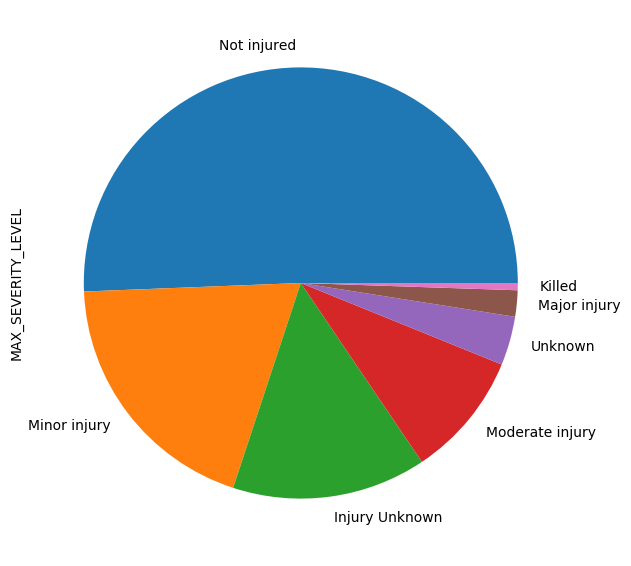

In [98]:
labels= {
0:'Not injured',
1:'Killed',
2:'Major injury',
3:'Moderate injury',
4:'Minor injury',
8:'Injury Unknown',
9:'Unknown'
}
severity_data = data['MAX_SEVERITY_LEVEL'].value_counts()
severity_data = severity_data.rename(labels)
severity_data.plot.pie(figsize=(7,7))
total = severity_data.sum()
sev = severity_data.apply(lambda x: str(x/total*100)[:5]+'%')
print('Sevirity precentages:\n')
print(sev)

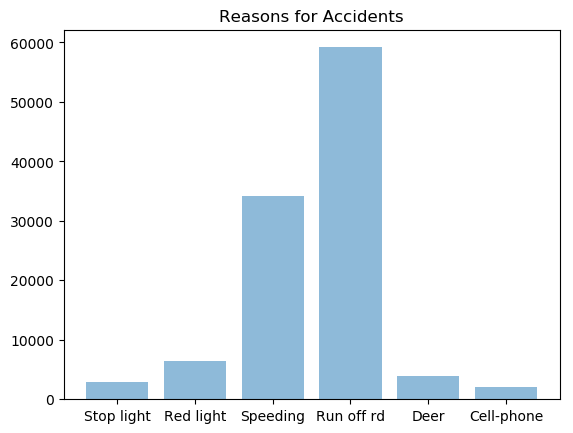

In [99]:
reasons = [
'RUNNING_STOP_SIGN',
'RUNNING_RED_LT',
'SPEEDING_RELATED',
'SV_RUN_OFF_RD',
'SUDDEN_DEER',
'CELL_PHONE',
]
labels = ['Stop light','Red light','Speeding','Run off rd','Deer','Cell-phone']
total = 0
counts = []
for i in reasons:
    total += len(data[data[i]==1].index)
    counts.append(len(data[data[i]==1].index))
y_pos = np.arange(len(reasons))
plt.rcdefaults()
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.title('Reasons for Accidents')
plt.show()

In [100]:
import pandas as pd
data = cleaning.get_data("crash.csv")
f = data['TIME_OF_DAY'].dropna()
f = data.loc[(data.TIME_OF_DAY > 0) & (data.TIME_OF_DAY < 2400)]

bins = [-np.inf,600,1200,1800,2400]

labels = ['Late night','Morning','Afternoon','Night']

f['time'] = pd.cut(data.TIME_OF_DAY, bins=bins, labels=labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


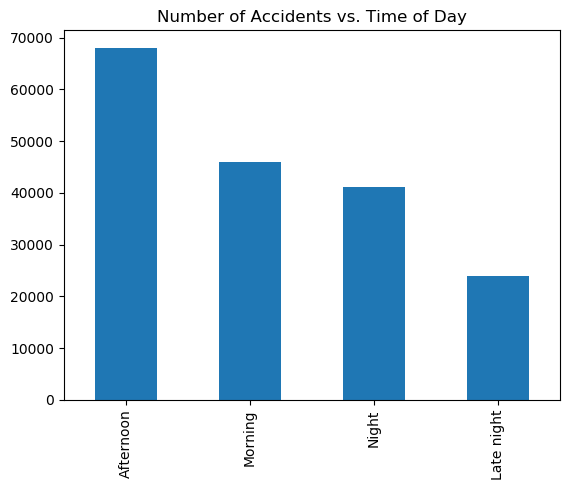

In [101]:
# Late night:12am-6am, morning :6am
plt.title('Number of Accidents vs. Time of Day')
f['time'].value_counts().plot(kind='bar')

Text(0.5,1,'Collision Types')

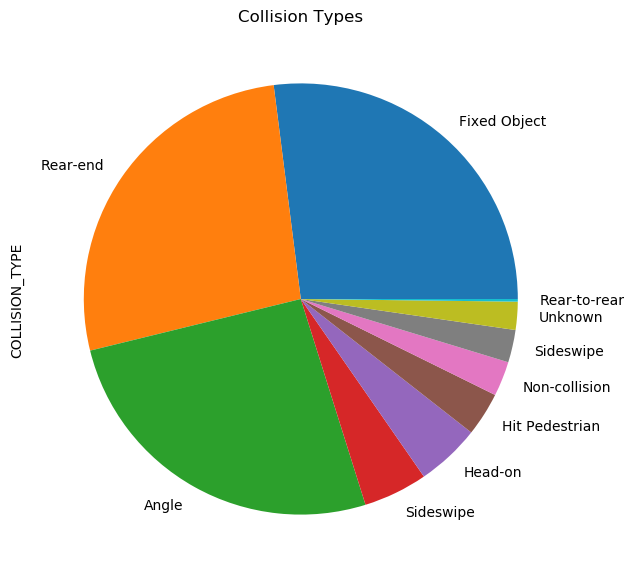

In [102]:
lab={
0 : 'Non-collision',
1 : 'Rear-end',
2 : 'Head-on',
3 : 'Rear-to-rear',
4 : 'Angle',
5 : 'Sideswipe' ,
6 : 'Sideswipe' , 
7 : 'Fixed Object',
8 : 'Hit Pedestrian',
9 : 'Unknown'}
col_data=data['COLLISION_TYPE'].value_counts()

col_data= col_data.rename(lab)
col_data.plot.pie(figsize=(7,7))
plt.title('Collision Types')

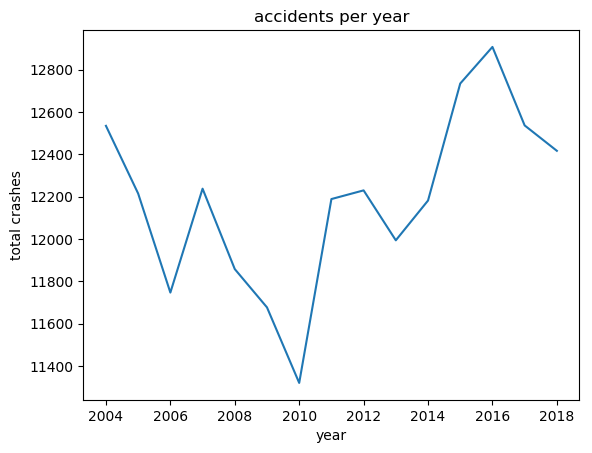

In [103]:
# Accidents per year
d = data
d['count']=1
d =data.groupby('CRASH_YEAR').agg(['sum']).reset_index()
x,y = d['CRASH_YEAR'],d['count']
plt.title('accidents per year')
plt.xlabel('year')
plt.ylabel('Total crashes')
plt.plot(x,y)

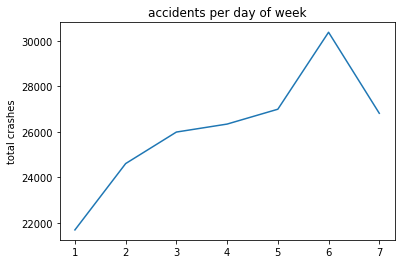

In [16]:
# Accidents per day of the week
d = data
d['count']=1
d =data.groupby('DAY_OF_WEEK').agg(['sum']).reset_index()
x,y = d['DAY_OF_WEEK'],d['count']
plt.title('Accidents per Day of Week')

plt.ylabel('Total Crashes')

plt.xticks([, ['Sunday','Monday','Tuesday','Wensday','Thursday','Friday','Saturday'])

plt.plot(x,y)